<a href="https://colab.research.google.com/github/asfaqahmedkazi/IMDBProject/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check the Dataset & Mount Google Drive**

In [1]:
#Connect to google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "/content/gdrive/MyDrive/IMDB Project Dataset"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

imdb_master.csv



# Library Section

In [3]:
################################################# import libraries ###########################################
!pip install plotly==3.10.0
import pandas as pd
import os
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import operator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
### Importing special library for Stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Modules Section**

---
Define all functions that will be used in the project

In [4]:
def rem_sw(df):
    # Downloading stop words
    stop_words = set(stopwords.words('english'))

    # Removing Stop words from training data
    count = 0
    for sentence in df:
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        df.loc[count] = sentence
        count+=1
    return(df)

In [5]:
def rem_punc(df):
    count = 0
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)

In [6]:
def lemma(df):

    lmtzr = WordNetLemmatizer()

    count = 0
    stemmed = []
    for sentence in df:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [7]:
def stemma(df):

    stemmer = SnowballStemmer("english") #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [8]:
def get_feature(df, number):
    
    feature_list = []
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Create the feature list
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)

In [9]:
def print_feature(df):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    # first create arrays holding input and output data

    # Vectorizing Train set
    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['review'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['label'])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

In [10]:
def get_bestrf(X, y):
    parameters = [
        {
            "n_estimators":[5, 10, 20, 50, 100],
            "criterion":['gini', 'entropy']
        }
    ]

    best_clf = GridSearchCV(clf, parameters, scoring="accuracy", verbose=5, n_jobs=4)

    best_clf.fit(X, y)
    
    return(best_clf.best_estimator_.n_estimators, best_clf.best_estimator_.criterion)

**Stage 1:**

---
Data Import & Cleaning

In [11]:
############################## Loading Data #########################################
df_master = pd.read_csv("/content/gdrive/MyDrive/IMDB Project Dataset/imdb_master.csv", encoding='latin-1', index_col = 0)

df_master.head()



,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [12]:
##################################### Removing Stop words from dataset ##################################
df_master['review'] = rem_sw(df_master['review'])

#Check the Dataset
df_master.head()

,type,review,label,file
0,test,mr. costner dragged movie far longer necessary...,neg,0_2.txt
1,test,example majority action films same. generic bo...,neg,10000_4.txt
2,test,"first hate moronic rappers, could'nt act gun p...",neg,10001_1.txt
3,test,"even beatles could write songs everyone liked,...",neg,10002_3.txt
4,test,brass pictures (movies fitting word them) real...,neg,10003_3.txt


In [13]:
###################################### Removing punctuations from the dataset ##################################
df_master['review'] = rem_punc(df_master['review'])

#Check the Dataset
df_master.head()

,type,review,label,file
0,test,mr costner dragged movie far longer necessary ...,neg,0_2.txt
1,test,example majority action films same generic bor...,neg,10000_4.txt
2,test,first hate moronic rappers couldnt act gun pre...,neg,10001_1.txt
3,test,even beatles could write songs everyone liked ...,neg,10002_3.txt
4,test,brass pictures movies fitting word them really...,neg,10003_3.txt


In [14]:
############################################### Stemming the dataset (Normanization) ##########################################

df_master['review'] = lemma(df_master['review'])
df_master['review'] = stemma(df_master['review'])

#Check the Dataset
df_master.head()

,type,review,label,file
0,test,mr costner drag movi far longer necessari asid...,neg,0_2.txt
1,test,exampl major action film same generic bore the...,neg,10000_4.txt
2,test,first hate moron rapper couldnt act gun press ...,neg,10001_1.txt
3,test,even beatl could write song everyon like altho...,neg,10002_3.txt
4,test,brass pictur movi fit word them realli somewha...,neg,10003_3.txt


In [15]:
###################################### Negative set frequency of train and test combined ################################

# Creating a new dataframe of stemmed data set with only Negative reviews
df_neg = df_master.query('label=="neg"')

# Vectorizing negative reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_neg.review)

# Visualising the high frequency words for negative set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
movi,58387
film,44962
like,24640
make,16205
bad,15847
time,15317
watch,14965
good,14918
charact,14319
realli,12353


In [16]:
###################################### Positive set frequency of train and test combined ################################

# Creating a dataframe of stemmed data set with only Positive reviews
df_pos = df_master.query('label=="pos"')

# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_pos.review)

# Visualising the high frequency words for positive set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq.nlargest(10, 'frequency')

,frequency
film,50860
movi,44822
like,20554
time,16619
good,15261
stori,14180
charact,14017
make,13807
great,13334
watch,12905


In [17]:
######################### Lowest and highest frequency words ###########################

# Vectorizing complete review set
vect = CountVectorizer(stop_words = 'english', analyzer='word')
vect_pos = vect.fit_transform(df_master.review)

# Visualising the high and low frequency words for complete set
df_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
print(df_freq.nlargest(1, 'frequency'), sep='\n')
print(df_freq.nsmallest(1, 'frequency'), sep='\t')

      frequency
movi     206796
       frequency
aaaaa          1


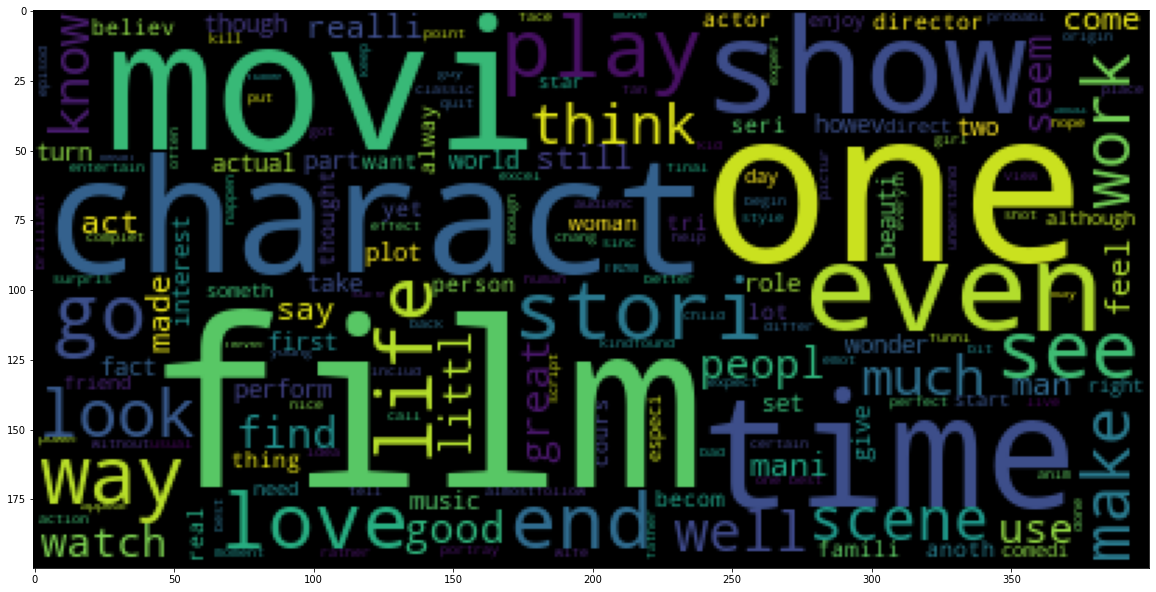

In [18]:
########################## WordCloud Positive Reviews ##################################
#Need to fix this
# Creating a list of train and test data to analyse
df_freq = df_pos
imdb_list = df_freq["review"][df_freq.label.isin(['pos'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for psitive words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

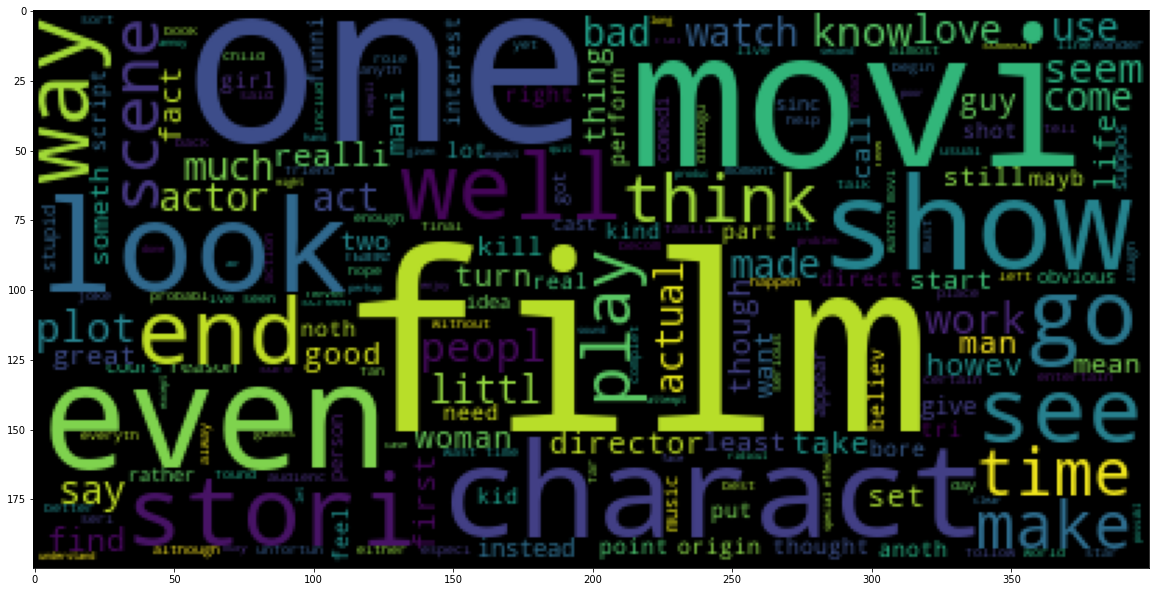

In [19]:
########################## WordCloud Negative Train & Test set ##################################

# Creating a list of train and test data to analyse
df_freq = df_neg
imdb_list = df_freq["review"][df_freq.label.isin(['neg'])].unique().tolist()
imdb_bow = " ".join(imdb_list)

# Create a word cloud for negative words
imdb_wordcloud = WordCloud().generate(imdb_bow)

# Show the created image of word cloud
plt.figure(figsize=(20, 20))
plt.imshow(imdb_wordcloud)
plt.show()

**Predicitive Modelling**


---
Creating required dataset and applying Machine Learning Model


**Naive Byers Model**

In [20]:
df_master.head()
df_TrainSep = df_master.query('type =="train"')
df_TestSep = df_master.query('type == "test"')
df_TrainSep.head()
df_TestSep.head()

,type,review,label,file
0,test,mr costner drag movi far longer necessari asid...,neg,0_2.txt
1,test,exampl major action film same generic bore the...,neg,10000_4.txt
2,test,first hate moron rapper couldnt act gun press ...,neg,10001_1.txt
3,test,even beatl could write song everyon like altho...,neg,10002_3.txt
4,test,brass pictur movi fit word them realli somewha...,neg,10003_3.txt


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression,SGDClassifier

Applying Naive Byers Model to the original 50-50 split for train & test

In [22]:
#######################################################################
#Splitting the whole datset with 50-50 Ratio as per the data provided
#######################################################################
################################## Preparing dataframe for model ##############################

imdb_temp = df_master.query('label != "unsup"')
imdb_full = imdb_temp[["review", "label"]]
df_algo = imdb_temp

################################## Splitting with feature selection data ###############################

# Vectorising the required data
vect_algo = TfidfVectorizer(stop_words='english', analyzer='word')
vect_algo.fit(df_TrainSep.review)
Xf_train = vect_algo.transform(df_algo[df_algo['type'].isin(['train'])].review)
Xf_test = vect_algo.transform(df_algo[df_algo['type'].isin(['test'])].review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
yf_train = le.fit_transform(df_algo[df_algo['type'].isin(['train'])].label)
yf_test = le.fit_transform(df_algo[df_algo['type'].isin(['test'])].label)

########################################### Naive Bayes #########################################

# Fit the Naive Bayes classifier model to the object
clf = MultinomialNB()
clf.fit(Xf_train, yf_train)

# predict the outcome for testing data
predictions = clf.predict(Xf_test)

# check the accuracy of the model
accuracy = accuracy_score(yf_test, predictions)
print("Observation: Naive Bayes Classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))

Observation: Naive Bayes Classification gives an accuracy of 81.84% on the testing data


**To increase efficiency of the model, splitting the dataset with 70-30 ratio for Train & test and aplying Naive Byers again**

In [23]:
####################################################################
# Splitting the whole datset into 70-30 ratio for Test & Train
####################################################################
################################## Preparing dataframe for model ##############################
imdb_temp = df_master.query('label != "unsup"')
imdb_full = imdb_temp[["review", "label"]]

################################## Splitting with feature selection data ###############################a
spt_train,spt_test = train_test_split(imdb_full,test_size=0.3, random_state=1)

################### Using TfidVectorizer to Count freq and create Sparse Matrix ###############################

# Vectorising the required data for train dataset
model_vect = TfidfVectorizer(stop_words='english', analyzer='word')
model_vect.fit(spt_train.review)
spf_x_train = model_vect.transform(spt_train.review)

# The test dataset do not need to have a count because it is going to be used for testing
# The CountVectorizer is only needed to be applied to the training dataset
spf_x_test = model_vect.transform(spt_test.review)

# Encoding target data
# Creating an object and fitting on target strings
le = LabelEncoder()
spf_y_train = le.fit_transform(spt_train.label)
spf_y_test = le.fit_transform(spt_test.label)

########################################### Naive Bayes #########################################

# Fit the Naive Bayes classifier model to the object
clf = MultinomialNB()
clf.fit(spf_x_train, spf_y_train)

# predict the outcome for testing data
predictions = clf.predict(spf_x_test)

# Print the classification reprt
print(classification_report(spf_y_test,predictions))

# check the accuracy of the model
accuracy = accuracy_score(spf_y_test, predictions)
print("Observation: Naive Bayes Classification gives an accuracy of %.2f%% on the testing data" %(accuracy*100))



              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7593
           1       0.86      0.85      0.86      7407

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000

Observation: Naive Bayes Classification gives an accuracy of 85.84% on the testing data


**Applying Logistic Regression Model on the same 70-30 split for comaprison**

In [32]:
#########################################################################
# Applying Logistic Regression Model to the same dataset with 70-30 Split
#########################################################################
# training the model
lr = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

# Fitting the Logistic Regression model to the train dataset
lr_tfidf = lr.fit(spf_x_train,spf_y_train)

# predict the outcome for testing data
lr_tfidf_predict=lr.predict(spf_x_test)

# Print the classification reprt
print(classification_report(spf_y_test,lr_tfidf_predict))

# check the accuracy of the model
lr_tfidf_score=accuracy_score(spf_y_test,lr_tfidf_predict)
print("Observation: Logistic Regression Model gives an accuracy of %.2f%% on the testing data" %(lr_tfidf_score*100))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      7593
           1       0.87      0.91      0.89      7407

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Observation: Logistic Regression Model gives an accuracy of 88.94% on the testing data


**Conclusion:**
*   Logistic Regression Model efficiency: **88.94%**
*   Naive Byers Model efficiency: **85.84%**

In [24]:
spt_train['label'].value_counts()

pos    17593
neg    17407
Name: label, dtype: int64

In [25]:
spt_test['label'].value_counts()

neg    7593
pos    7407
Name: label, dtype: int64

In [26]:
spf_x_train

<35000x61671 sparse matrix of type '<class 'numpy.float64'>'
	with 2920207 stored elements in Compressed Sparse Row format>

In [27]:
spf_x_test

<15000x61671 sparse matrix of type '<class 'numpy.float64'>'
	with 1228840 stored elements in Compressed Sparse Row format>